# Predikce vývoje cen akcí Mastercard

Vytvoříme různé modely, které se snaží předpověděť cenu akcí Mastercard.

# Data

- Date - datum
- Open - otevírací cena
- High - maximální cena
- Low - minimální cena
- Close - uzavírací cena
- Volume - obchodované množství akcií
- Dividens - Vyplacené dividendy
- Stock Splits - Rozdělení akcií je situace, kdy společnost zvýší počet svých akcií v oběhu, aby zvýšila jejich likviditu.


Pro predikce budeme používat sloupec High.

# Načtení dat a datová analýza

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Načteme si data a rovnou zahodíme nepotřebné sloupce.

In [ ]:
dataset = pd.read_csv("..\\dataset\\Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]).drop(["Dividends", "Stock Splits"], axis=1)

In [ ]:
dataset.head()

In [ ]:
dataset.describe()

In [ ]:
dataset.isna().sum()

Vykreslení grafu vývoje akcie
* Pro učení budeme používat data 2016 a 2020
* Pro ověření modelu budeme používat data z roku 2021

In [ ]:
trainig_start = 2016
training_end = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{trainig_start}":f"{training_end}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{training_end + 1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Před {tend+1})", f"Test ({tend+1} a dále)"])
    plt.title("Cena akcí MasterCard")
    plt.show()

train_test_plot(dataset,trainig_start,training_end)

# Příprava dat

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Rozdělení dat na trénovací a testovací.

- Trénovací jsou od 2016 do 2021. 
- Testovací jsou za rok 2021.

In [ ]:
trainig_start = 2016
training_end = 2020

def train_test_split(dataset, trainig_start, training_end):
    train = dataset.loc[f"{trainig_start}":f"{training_end}", "High"].values
    test = dataset.loc[f"{training_end+1}":, "High"].values
    return train, test

training_data, testing_data = train_test_split(dataset, trainig_start, training_end)

In [ ]:
print (f"Training data shape {training_data.shape}")
print (f"Testing data shape {testing_data.shape}")

Kontrolní zobrazení vstupních dat

In [ ]:
training_data[0]

Ke standardizaci trénovacího souboru použijeme funkci MinMaxScaler, která nám pomůže vyhnout se odlehlým hodnotám nebo anomáliím. 

Můžete také zkusit použít funkci StandardScaler nebo jakoukoli jinou skalární funkci pro normalizaci dat a zlepšení výkonu modelu.

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_data = training_data.reshape(-1, 1)
training_data_scaled = sc.fit_transform(training_data)

Kontrolní zobrazení první standardizovaná ceny akcie

In [ ]:
training_data_scaled[0]

Funkce split_sequence používá trénovací datovou sadu a převádí ji na vstupy (X_train) a výstupy (y_train).

Pokud je například sekvence [1,2,3,4,5,6,7,8,9,10,11,12] a n_step je tři, pak převede sekvenci na tři vstupní časové značky a jeden výstup.

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 80
features = 1

X_train, y_train = split_sequence(training_data_scaled, n_steps)



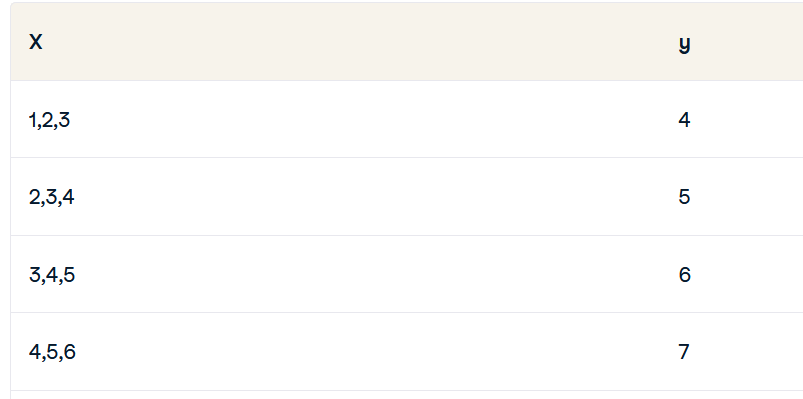

Kontrolní zobrazení tvaru matic

In [ ]:
print (X_train.shape)
print (y_train.shape)

Kontrolní zobrazení trénovacích dat

In [ ]:
X_train[0]

Kontrolní zobrazení výstupních dat

In [ ]:
y_train[0]

Pracujeme s jednorozměrnými řadami, takže počet funkcí je jedna, a potřebujeme přetvořit X_train tak, aby odpovídal modelu LSTM. 

X_train má [samples, timesteps] a my jej přetvoříme na [samples, timesteps, features].

V našem případě je features = 1

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

Upravení trénovacích dat

In [ ]:
inputs = testing_data
inputs = inputs.reshape(-1, 1)

# standardization
inputs = sc.transform(inputs)

# Splitting data
X_test, y_test = split_sequence(inputs, n_steps)

# Reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

# Jednoduchá RNN
První modelem bude jednoduchá rekurentní neuronová síť.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input

Zase se bude jednat o sekvenční síť.

In [ ]:
model_simple = Sequential()

Vstupní data mají následující rozměry:
* features = 1, jedna proměnná
* n_steps = 80, řada 80 vstupních hodnot

In [ ]:
model_simple.add(Input(shape=(n_steps, features))) 

Můžete experimentovat s počtem jednotek units, protože více jednotek vám poskytne lepší výsledky. 

* units
* activation - akvivační funkce

In [ ]:
model_simple.add(SimpleRNN(units=125,                          
                           activation="tanh",                 
                           ))  

Pak přidáme výstupní vrstvu, která vrací jednu hodnotu.

In [ ]:
model_simple.add(Dense(units=1))

Výpis struktury sítě.

In [ ]:
model_simple.summary()

In [ ]:
from keras_visualizer import visualizer 
visualizer(model_simple, file_format='png', view=True)

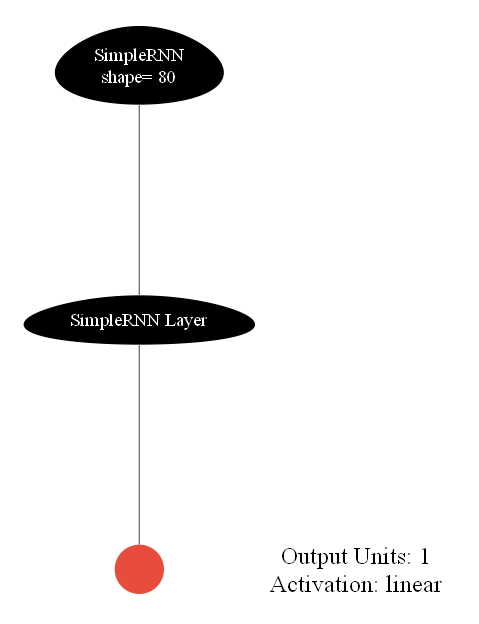

Nastavení učebních parametrů

In [ ]:
model_simple.compile(optimizer="RMSprop", loss="mse", metrics=['mae'])

Vytvoření earlystop

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=30)

Učení neuronové sítě

In [ ]:
history_simple=model_simple.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop])

### Zobrazení historie učení

In [ ]:
plt.plot(history_simple.history['loss'], label='Train Loss')
plt.plot(history_simple.history['mae'], label='Train MAE')
plt.legend(loc="right")
plt.title('Loss and MAE')
plt.ylabel('Loss and MAE')
plt.xlabel('Počet epoch')
plt.show()

### Ověření modelu

Predikce budoucích hodnot akcie

In [ ]:
predicted_stock_price = model_simple.predict(X_test)

Inverze výsledku ze standardizovaných hodnota na skutečné

In [ ]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#### Zobrazení grafu

In [ ]:
def plot_predictions(test, predicted):
    """ Vykreslení předpovídaných a skutečných hodnot akcí 
    """
    
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

In [ ]:
plot_predictions(testing_data[0:y_test.shape[0]], predicted_stock_price)

#### RMSE 
Odchylky skutečných a predikovaných hodnot.

Pozor jedná se absolutní číslo.

In [ ]:
def return_rmse(test, predicted):    
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("RMSE {:.2f}.".format(rmse))
    
return_rmse(testing_data[0:y_test.shape[0]], predicted_stock_price)

#### sMAPE

Pro vyhodnocování časových řad je lepší metrika sMAPE. Často se udává v procentech.

sMAPE = mean( |y − ŷ| / (|y| + |ŷ|) )

In [ ]:
# převedení na vektory
y_true = testing_data[0:y_test.shape[0]]
y_pred = predicted_stock_price
y_true = y_true.reshape(-1)
y_pred = y_pred.reshape(-1)

In [ ]:
import numpy as np

def smape(y_true, y_pred, eps=1e-8):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(numerator / (denominator + eps)) * 100

Predikce se často netrefila.

In [ ]:
smape_value = smape(y_true, y_pred)
print(f"sMAPE: {smape_value:.2f} %")

#### Directional Accuracy (DA)
Někdy může být důležitý pouze směr a ne velikost. 

Například u financí to může naznačovat, zda kupovat nebo prodávat. 

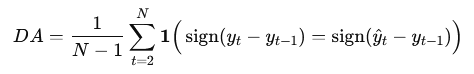

In [ ]:
def directional_accuracy(y_true, y_pred):
    true_diff = y_true[1:] - y_true[:-1]
    pred_diff = y_pred[1:] - y_true[:-1]

    correct_direction = np.sign(true_diff) == np.sign(pred_diff)
    return np.mean(correct_direction)

In [ ]:
da = directional_accuracy(y_true, y_pred) * 100
print(f"Directional Accuracy: {da:.3f} %")

# Neuronová síť LTSM

In [ ]:
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.optimizers import SGD

Model se skládá z jedné skryté vrstvy LSTM a výstupní vrstvy. 

Můžete experimentovat s počtem jednotek, protože více jednotek vám poskytne lepší výsledky. 

Pro tento experiment nastavíme počet jednotek LSTM na 125, jako aktivaci tanh a nastavíme velikost vstupu.

Nakonec model sestavíme pomocí optimalizátoru RMSprop a střední kvadratické chyby jako ztrátové funkce.

In [ ]:
model_ltsm = Sequential()
model_ltsm.add(Input(shape=(n_steps, features))) 
model_ltsm.add(LSTM(units=125, activation="tanh"))
model_ltsm.add(Dense(units=1))

Zobrazení struktury sítě.

In [ ]:
model_ltsm.summary()

In [ ]:
from keras_visualizer import visualizer 
visualizer(model_ltsm, file_format='png', view=True)

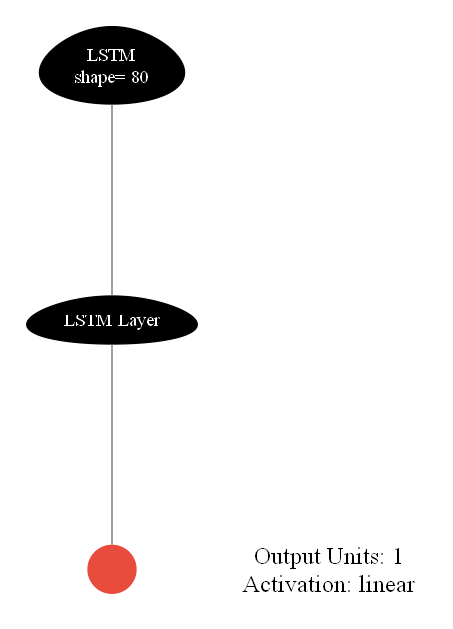

Kompilace a trénování sítě

In [ ]:
model_ltsm.compile(optimizer="RMSprop", loss="mse", metrics=['mae'])

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=30)

In [ ]:
history_ltsm=model_ltsm.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop])

### Zobrazení historie učení

In [ ]:
plt.plot(history_ltsm.history['loss'], label='Train Loss')
plt.plot(history_ltsm.history['mae'], label='Train MAE')
plt.legend(loc="right")
plt.title('Loss, MAE')
plt.ylabel('Loss, MAE')
plt.xlabel('Počet epoch')
plt.show()

### Ověření modelu LTSM

In [ ]:
predicted_stock_price = model_ltsm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#### Graf

In [ ]:
plot_predictions(testing_data[0:y_test.shape[0]], predicted_stock_price)

#### RMSE

In [ ]:
return_rmse(testing_data[0:y_test.shape[0]], predicted_stock_price)

#### sMAPE

In [ ]:
# převedení na vektory
y_true = testing_data[0:y_test.shape[0]]
y_pred = predicted_stock_price
y_true = y_true.reshape(-1)
y_pred = y_pred.reshape(-1)

In [ ]:
smape_value = smape(y_true, y_pred)
print(f"sMAPE: {smape_value:.2f} %")

#### Directional Accuracy (DA)

In [ ]:
da = directional_accuracy(y_true, y_pred) * 100
print(f"Directional Accuracy: {da:.3f} %")

# Model GRU
Model založený na Gated recurrent unit.

In [ ]:
model_gru = Sequential()
model_gru.add(Input(shape=(n_steps, features))) 
model_gru.add(GRU(units=125, activation="tanh"))
model_gru.add(Dense(units=1))

Zobrazení struktury sítě

In [ ]:
model_gru.summary()

In [ ]:
from keras_visualizer import visualizer 
visualizer(model_gru, file_format='png', view=True)

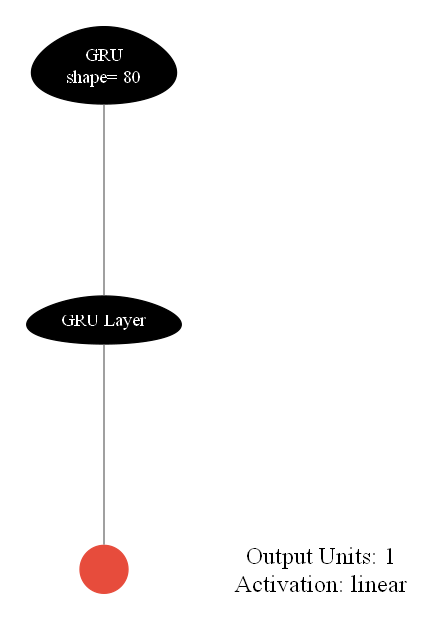

Trénování neuronové sítě

In [ ]:
model_gru.compile(optimizer="RMSprop", loss="mse", metrics=['mae'])
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=30)

In [ ]:
history_gru=model_gru.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop])

### Zobrazení historie učení

In [ ]:
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['mae'], label='Train MAE')
plt.legend(loc="right")
plt.title('Loss, MAE')
plt.ylabel('Loss, MAE')
plt.xlabel('Počet epoch')
plt.show()

### Ověření GRU modelu

In [ ]:
predicted_stock_price = model_gru.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#### Graf

In [ ]:
plot_predictions(testing_data[0:y_test.shape[0]], predicted_stock_price)

#### RMSE

In [ ]:
return_rmse(testing_data[0:y_test.shape[0]], predicted_stock_price)

#### sMAPE

In [ ]:
# převedení na vektory
y_true = testing_data[0:y_test.shape[0]]
y_pred = predicted_stock_price
y_true = y_true.reshape(-1)
y_pred = y_pred.reshape(-1)

In [ ]:
smape_value = smape(y_true, y_pred)
print(f"sMAPE: {smape_value:.2f} %")

#### Directional Accuracy (DA)

In [ ]:
da = directional_accuracy(y_true, y_pred) * 100
print(f"Directional Accuracy: {da:.3f} %")